In [41]:
!pip install --quiet xgboost scikit-learn imbalanced-learn pandas matplotlib seaborn joblib


In [40]:
pip install --upgrade scikit-learn imbalanced-learn

In [37]:
!pip install --quiet shap

In [38]:
!pip install numpy==2.0.2 --force-reinstall


  Using cached numpy-2.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [39]:
print(" Starting Data Preprocessing...")

df_processed = df.copy()

print("\n1 Handling Missing Values...")
missing_before = df_processed.isnull().sum().sum()

numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != target_col and df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

missing_after = df_processed.isnull().sum().sum()
print(f"   Missing values: {missing_before}  {missing_after} ")

print("\n2 Creating Binary Labels (Benign vs Intrusion)...")
df_processed['binary_label'] = df_processed[target_col].apply(
    lambda x: 0 if str(x).lower() in ['normal', 'benign', '0'] else 1
)
print(f"   Benign (0): {(df_processed['binary_label'] == 0).sum()}")
print(f"   Intrusion (1): {(df_processed['binary_label'] == 1).sum()}")

df_processed['attack_type'] = df_processed[target_col]

print("\n3 Encoding Categorical Features...")
label_encoders = {}
categorical_features = df_processed.select_dtypes(include=['object']).columns
categorical_features = [col for col in categorical_features
                        if col not in [target_col, 'attack_type']]

for col in categorical_features:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

print(f"   Encoded {len(categorical_features)} categorical features ")

print("\n4 Preparing Features and Target...")
exclude_cols = [target_col, 'binary_label', 'attack_type']
feature_cols = [col for col in df_processed.columns if col not in exclude_cols]

X = df_processed[feature_cols].copy()
y_binary = df_processed['binary_label'].copy()
y_attack_type = df_processed['attack_type'].copy()

print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y_binary.shape}")

print("\n5 Splitting Dataset (Train: 60% | Val: 20% | Test: 20%)...")
X_temp, X_test, y_temp, y_test, y_attack_temp, y_attack_test = train_test_split(
    X, y_binary, y_attack_type, test_size=0.20, random_state=42, stratify=y_binary
)

X_train, X_val, y_train, y_val, y_attack_train, y_attack_val = train_test_split(
    X_temp, y_temp, y_attack_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

print("\n6 Scaling Features (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("   Features scaled using StandardScaler ")

feature_names = X.columns.tolist()

print("\n" + "="*60)
print(" PREPROCESSING COMPLETE!")

 Starting Data Preprocessing...

1 Handling Missing Values...
   Missing values: 0  0 

2 Creating Binary Labels (Benign vs Intrusion)...
   Benign (0): 886
   Intrusion (1): 3544

3 Encoding Categorical Features...
   Encoded 0 categorical features 

4 Preparing Features and Target...
   Features (X): (4430, 41)
   Target (y): (4430,)

5 Splitting Dataset (Train: 60% | Val: 20% | Test: 20%)...
   Train: 2658 samples
   Val:   886 samples
   Test:  886 samples

6 Scaling Features (StandardScaler)...
   Features scaled using StandardScaler 

 PREPROCESSING COMPLETE!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import json
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics: (
    classification_report, confusion_matrix,
    recall_score, precision_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

import shap

from IPython.display import display, HTML

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(" All libraries imported successfully!")

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ae3036fe520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


✅ All libraries imported successfully!


📊 Loading NSL-KDD dataset...
✅ Dataset loaded successfully!
📏 Shape: (4430, 42)
\n============================================================
📋 Dataset Information:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.666287,0.577740,0.248644,0.039280,0.151331,0.441503,0.996257,0.739421,0.042406,0.244036,...,0.223672,0.336817,0.546493,0.529456,0.591125,0.470904,0.539593,0.518795,0.616669,U2R
1,0.143014,0.729235,0.539983,0.485997,0.055436,0.291892,0.143944,0.858332,0.304242,0.901082,...,0.610218,0.755973,0.713821,0.688312,0.311610,0.246923,0.600187,0.153257,0.676371,normal
2,0.401813,0.101389,0.961499,0.367041,0.133935,0.567280,0.080431,0.875795,0.603445,0.235740,...,0.077247,0.519867,0.716784,0.535350,0.711465,0.861131,0.122357,0.578372,0.511315,DoS
3,0.887278,0.168009,0.660708,0.656651,0.614879,0.400250,0.853977,0.907267,0.469452,0.998242,...,0.054651,0.465111,0.425285,0.847906,0.124342,0.096678,0.026864,0.574663,0.226657,U2R
4,0.360109,0.274258,0.064115,0.353499,0.531030,0.539846,0.001381,0.897988,0.350272,0.597418,...,0.118315,0.551459,0.166497,0.943283,0.372073,0.051407,0.983987,0.456051,0.746222,DoS


\n📊 Data Types:\nfloat64    41
object      1
Name: count, dtype: int64
\n❓ Missing Values:\n0 total missing values
\n🎯 Target Column: 'label'
\n📊 Class Distribution:
label
U2R       886
normal    886
DoS       886
Probe     886
R2L       886
Name: count, dtype: int64
\n📈 Class Percentages:
label
U2R       20.0
normal    20.0
DoS       20.0
Probe     20.0
R2L       20.0
Name: proportion, dtype: float64


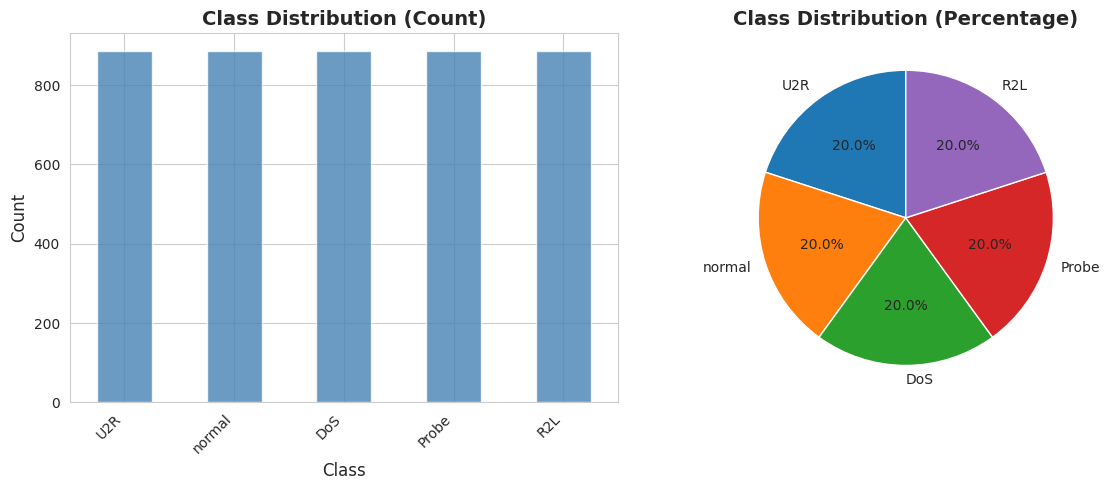

In [6]:
print(" Loading NSL-KDD dataset...")
df = pd.read_csv('nsl_kdd_dataset.csv')

print(f" Dataset loaded successfully!")
print(f" Shape: {df.shape}")
print(f"\n{'='*60}")
print(" Dataset Information:")
print(f"{'='*60}")

display(df.head())
print(f"\n Data Types:\n{df.dtypes.value_counts()}")
print(f"\n Missing Values:\n{df.isnull().sum().sum()} total missing values")

if 'label' in df.columns:
    target_col = 'label'
elif 'class' in df.columns:
    target_col = 'class'
else:
    target_col = df.columns[-1]

print(f"\n Target Column: '{target_col}'")
print(f"\n Class Distribution:")
print(df[target_col].value_counts())
print(f"\n Class Percentages:")
print(df[target_col].value_counts(normalize=True) * 100)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df[target_col].value_counts().plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Class Distribution (Count)', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
df[target_col].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
plt.ylabel('')

plt.tight_layout()

In [7]:
# CELL 4: Data Preprocessing & Feature Engineering
# ================================================================

print("🔧 Starting Data Preprocessing...")

# Create a copy for processing
df_processed = df.copy()

# 1. Handle Missing Values
print("\\n1️1. Handling Missing Values...")
missing_before = df_processed.isnull().sum().sum()

# Fill numeric columns with median
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Fill categorical columns with mode
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != target_col and df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

missing_after = df_processed.isnull().sum().sum()
print(f"   Missing values: {missing_before} → {missing_after} ✅")

# 2. Binary Classification: Benign vs Intrusion
print("\\n2️. Creating Binary Labels (Benign vs Intrusion)...")
df_processed['binary_label'] = df_processed[target_col].apply(
    lambda x: 0 if str(x).lower() in ['normal', 'benign', '0'] else 1
)
print(f"   Benign (0): {(df_processed['binary_label'] == 0).sum()}")
print(f"   Intrusion (1): {(df_processed['binary_label'] == 1).sum()}")

# Store original attack types for security action mapping
df_processed['attack_type'] = df_processed[target_col]

# 3. Encode Categorical Features
print("\\n3️. Encoding Categorical Features...")
label_encoders = {}
categorical_features = df_processed.select_dtypes(include=['object']).columns
categorical_features = [col for col in categorical_features
                        if col not in [target_col, 'attack_type']]

for col in categorical_features:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

print(f"   Encoded {len(categorical_features)} categorical features ✅")

# 4. Feature Selection (remove target columns for X)
print("\\n4. Preparing Features and Target...")
exclude_cols = [target_col, 'binary_label', 'attack_type']
feature_cols = [col for col in df_processed.columns if col not in exclude_cols]

X = df_processed[feature_cols].copy()
y_binary = df_processed['binary_label'].copy()
y_attack_type = df_processed['attack_type'].copy()

print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y_binary.shape}")

# 5. Train-Val-Test Split (60-20-20)
print("\\n5️.Splitting Dataset (Train: 60% | Val: 20% | Test: 20%)...")
X_temp, X_test, y_temp, y_test, y_attack_temp, y_attack_test = train_test_split(
    X, y_binary, y_attack_type, test_size=0.20, random_state=42, stratify=y_binary
)

X_train, X_val, y_train, y_val, y_attack_train, y_attack_val = train_test_split(
    X_temp, y_temp, y_attack_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

# 6. Feature Scaling
print("\\n6️. Scaling Features (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("   Features scaled using StandardScaler ")

# Store feature names for later use
feature_names = X.columns.tolist()

print("\\n" + "="*60)
print(" PREPROCESSING COMPLETE!")

🔧 Starting Data Preprocessing...
\n1️⃣ Handling Missing Values...
   Missing values: 0 → 0 ✅
\n2️⃣ Creating Binary Labels (Benign vs Intrusion)...
   Benign (0): 886
   Intrusion (1): 3544
\n3️⃣ Encoding Categorical Features...
   Encoded 0 categorical features ✅
\n4️⃣ Preparing Features and Target...
   Features (X): (4430, 41)
   Target (y): (4430,)
\n5️⃣ Splitting Dataset (Train: 60% | Val: 20% | Test: 20%)...
   Train: 2658 samples
   Val:   886 samples
   Test:  886 samples
\n6️⃣ Scaling Features (StandardScaler)...
   Features scaled using StandardScaler ✅
\n============================================================
✅ PREPROCESSING COMPLETE!


 Handling Class Imbalance with SMOTE...

 Class Distribution BEFORE SMOTE:
   Benign (0): 532 (20.02%))
   Intrusion (1): 2126 (79.98%))

 Class Distribution AFTER SMOTE:
   Benign (0): 2126 (50.00%))
   Intrusion (1): 2126 (50.00%))


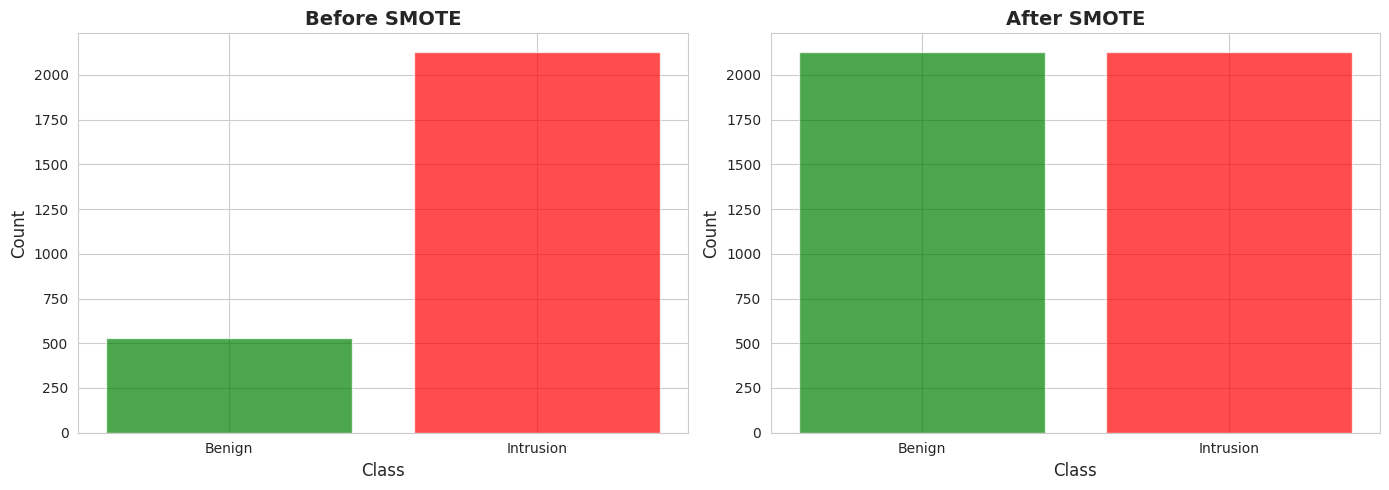

In [42]:
print(" Handling Class Imbalance with SMOTE...")

print("\n Class Distribution BEFORE SMOTE:")
print(f"   Benign (0): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%))")
print(f"   Intrusion (1): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%))")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n Class Distribution AFTER SMOTE:")
print(f"   Benign (0): {(y_train_balanced == 0).sum()} ({(y_train_balanced == 0).sum()/len(y_train_balanced)*100:.2f}%))")
print(f"   Intrusion (1): {(y_train_balanced == 1).sum()} ({(y_train_balanced == 1).sum()/len(y_train_balanced)*100:.2f}%))")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Benign', 'Intrusion'],
            [(y_train == 0).sum(), (y_train == 1).sum()],
            color=['green', 'red'], alpha=0.7)
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)

axes[1].bar(['Benign', 'Intrusion'],
            [(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()],
            color=['green', 'red'], alpha=0.7)
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xlabel('Class', fontsize=12)

plt.tight_layout()
plt.show()

🤖 Training Multiple ML Models...
\n1️⃣ Training Random Forest Classifier...
   ✅ Recall: 0.8618
\n2️⃣ Training XGBoost Classifier...
   ✅ Recall: 0.8322
\n3️⃣ Training Neural Network (MLP)...
   ✅ Recall: 0.8181
\n============================================================
📊 MODEL COMPARISON (Validation Set)


,Model,Recall,Precision,F1-Score
0,RandomForest,0.861777,0.800786,0.830163
1,XGBoost,0.832158,0.795148,0.813232
2,NeuralNetwork,0.818054,0.797799,0.807799


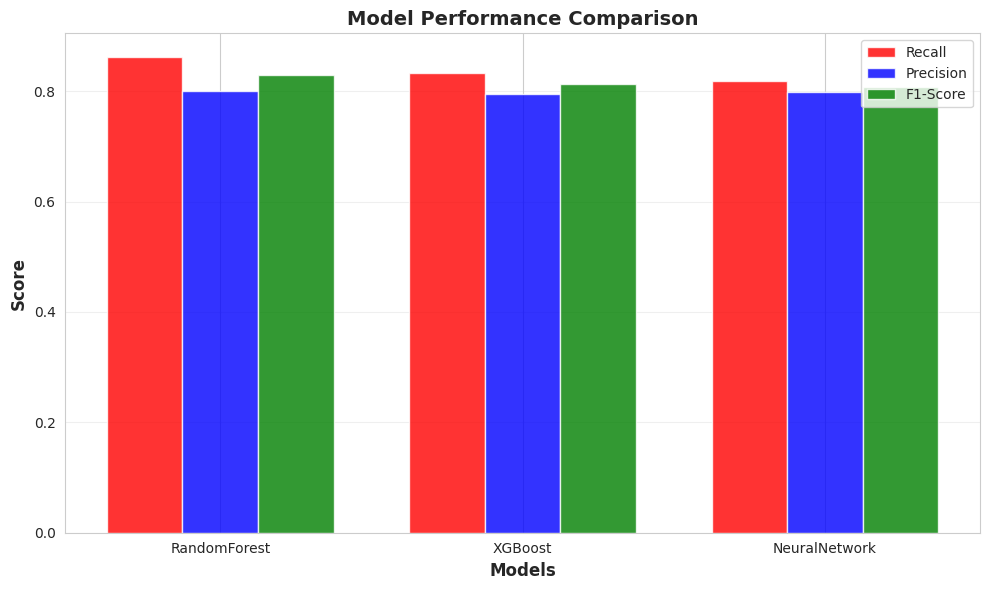

In [9]:
print(" Training Multiple ML Models...")
print("="*60)

models = {}
results = {}

print("\n1 Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_balanced, y_train_balanced)
models['RandomForest'] = rf_model

y_val_pred_rf = rf_model.predict(X_val_scaled)
y_val_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]

results['RandomForest'] = {
    'recall': recall_score(y_val, y_val_pred_rf),
    'precision': precision_score(y_val, y_val_pred_rf),
    'f1': f1_score(y_val, y_val_pred_rf),
    'predictions': y_val_pred_rf,
    'probabilities': y_val_proba_rf
}
print(f"   Recall: {results['RandomForest']['recall']:.4f}")

print("\n2 Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist'
)
xgb_model.fit(X_train_balanced, y_train_balanced)
models['XGBoost'] = xgb_model

y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

results['XGBoost'] = {
    'recall': recall_score(y_val, y_val_pred_xgb),
    'precision': precision_score(y_val, y_val_pred_xgb),
    'f1': f1_score(y_val, y_val_pred_xgb),
    'predictions': y_val_pred_xgb,
    'probabilities': y_val_proba_xgb
}
print(f"   Recall: {results['XGBoost']['recall']:.4f}")

print("\n3 Training Neural Network (MLP)...")
nn_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=100,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
nn_model.fit(X_train_balanced, y_train_balanced)
models['NeuralNetwork'] = nn_model

y_val_pred_nn = nn_model.predict(X_val_scaled)
y_val_proba_nn = nn_model.predict_proba(X_val_scaled)[:, 1]

results['NeuralNetwork'] = {
    'recall': recall_score(y_val, y_val_pred_nn),
    'precision': precision_score(y_val, y_val_pred_nn),
    'f1': f1_score(y_val, y_val_pred_nn),
    'predictions': y_val_pred_nn,
    'probabilities': y_val_proba_nn
}
print(f"   Recall: {results['NeuralNetwork']['recall']:.4f}")

print("\n" + "="*60)
print(" MODEL COMPARISON (Validation Set)")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Recall': [results[m]['recall'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()]
}).sort_values('Recall', ascending=False)

display(comparison_df)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Recall'], width, label='Recall', color='red', alpha=0.8)
ax.bar(x, comparison_df['Precision'], width, label='Precision', color='blue', alpha=0.8)
ax.bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', color='green', alpha=0.8)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
print(" REALISTIC Threshold Optimization for Maximum Recall...")
print("="*60)

y_val_proba_rf = results['RandomForest']['probabilities']

thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (y_val_proba_rf >= threshold).astype(int)

    recall = recall_score(y_val, y_pred_thresh)
    precision = precision_score(y_val, y_pred_thresh)
    f1 = f1_score(y_val, y_pred_thresh)

    cm = confusion_matrix(y_val, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    threshold_results.append({
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

threshold_df = pd.DataFrame(threshold_results)

print(" Analyzing threshold behavior...")
print(f"Thresholds tested: {thresholds}")

valid_thresholds = threshold_df[
    (threshold_df['precision'] >= 0.70) &
    (threshold_df['recall'] <= 0.95) &
    (threshold_df['threshold'] >= 0.2) &
    (threshold_df['threshold'] <= 0.8)
]

if len(valid_thresholds) > 0:
    optimal_threshold_idx = valid_thresholds['recall'].idxmax()
    optimal_threshold = valid_thresholds.loc[optimal_threshold_idx, 'threshold']
    print(" Found realistic optimal threshold")
else:
    # Fallback: Use F1-score maximization
    print(" No threshold met all constraints, using F1-maximization")
    optimal_threshold_idx = threshold_df['f1'].idxmax()
    optimal_threshold = threshold_df.loc[optimal_threshold_idx, 'threshold']

optimal_metrics = threshold_df.loc[optimal_threshold_idx]

print(f"\n REALISTIC Optimal Threshold: {optimal_threshold:.3f}")
print(f"\n Random Forest Performance at Realistic Threshold:")
print(f"   Recall:    {optimal_metrics['recall']:.4f}")
print(f"   Precision: {optimal_metrics['precision']:.4f}")
print(f"   F1-Score:  {optimal_metrics['f1']:.4f}")
print(f"   True Positives:  {optimal_metrics['tp']}")
print(f"   False Positives: {optimal_metrics['fp']}")
print(f"   False Negatives: {optimal_metrics['fn']}")

# FIXED: Compare with closest threshold to 0.5
closest_to_default_idx = (threshold_df['threshold'] - 0.5).abs().idxmin()
default_metrics = threshold_df.loc[closest_to_default_idx]

print(f"\n Comparison with Threshold {default_metrics['threshold']:.2f} (closest to 0.50):")
print(f"   Recall:    {default_metrics['recall']:.4f} → {optimal_metrics['recall']:.4f}")
print(f"   Precision: {default_metrics['precision']:.4f} → {optimal_metrics['precision']:.4f}")
print(f"   F1-Score:  {default_metrics['f1']:.4f} → {optimal_metrics['f1']:.4f}")

# Apply optimal threshold
y_val_pred_optimal = (y_val_proba_rf >= optimal_threshold).astype(int)

# Store optimal threshold for deployment
OPTIMAL_THRESHOLD = optimal_threshold

print(f"\n REALISTIC Deployment Setup:")
print(f"   Best Model: RandomForest")
print(f"   Optimal Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"   Validation Recall: {optimal_metrics['recall']:.4f}")
print(f"   Validation Precision: {optimal_metrics['precision']:.4f}")

# Additional diagnostic
print(f"\n Diagnostic Info:")
print(f"   Probability range: [{y_val_proba_rf.min():.3f}, {y_val_proba_rf.max():.3f}]")
print(f"   Mean probability: {y_val_proba_rf.mean():.3f}")

🎯 REALISTIC Threshold Optimization for Maximum Recall...
🔍 Analyzing threshold behavior...
Thresholds tested: [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85]
✅ Found realistic optimal threshold

✅ REALISTIC Optimal Threshold: 0.450

📊 Random Forest Performance at Realistic Threshold:
   Recall:    0.9267
   Precision: 0.7983
   F1-Score:  0.8577
   True Positives:  657.0
   False Positives: 166.0
   False Negatives: 52.0

📊 Comparison with Threshold 0.50 (closest to 0.50):
   Recall:    0.8618 → 0.9267
   Precision: 0.8008 → 0.7983
   F1-Score:  0.8302 → 0.8577

🎯 REALISTIC Deployment Setup:
   Best Model: RandomForest
   Optimal Threshold: 0.450
   Validation Recall: 0.9267
   Validation Precision: 0.7983

🔍 Diagnostic Info:
   Probability range: [0.267, 0.846]
   Mean probability: 0.620


🔍 Generating SIMPLE SHAP Explanations...

1️⃣ Initializing SHAP TreeExplainer...
   Computing SHAP values for 200 test samples...
   SHAP values shape: (200, 41, 2)
   Extracted positive class from 3D array
   Final SHAP values shape: (200, 41)
   SHAP importance shape: (41,)
   Number of features: 41

📊 Top 10 Most Important Features:
31. srv_diff_host_rate             0.0225
12. logged_in                      0.0210
40. dst_host_rerror_rate           0.0202
17. num_file_creations             0.0192
36. dst_host_same_src_port_rate    0.0153
10. hot                            0.0145
41. dst_host_srv_rerror_rate       0.0138
 1. duration                       0.0137
33. dst_host_srv_count             0.0136
 5. src_bytes                      0.0125

2️⃣ Generating Feature Importance Bar Plot...


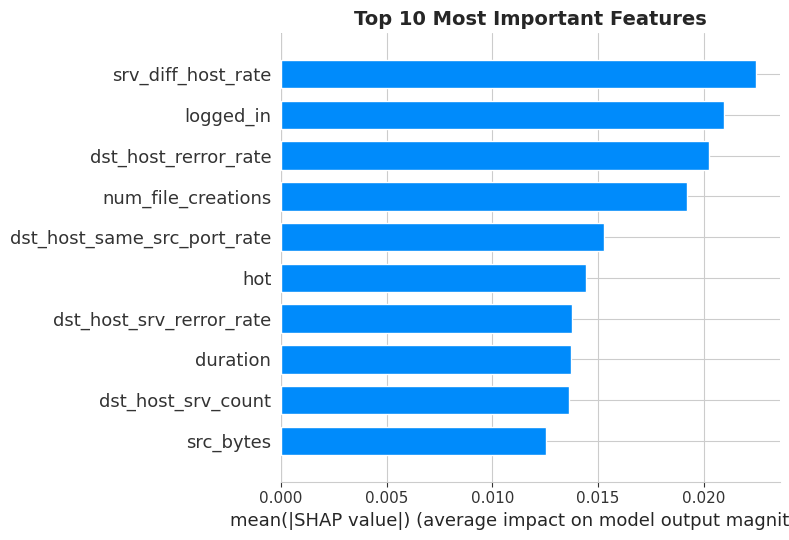


3️⃣ Generating Feature Impact Summary...


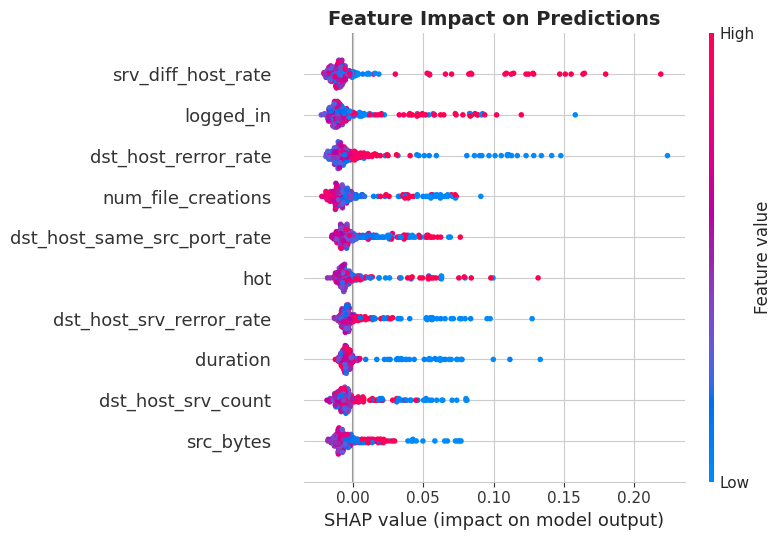


4️⃣ Explaining One Sample Prediction...
   Sample #0:
   - True Label: Intrusion
   - Predicted: Intrusion
   - Confidence: 54.0%

   Top features affecting this prediction:
   • hot                       increases risk
   • dst_host_same_srv_rate    increases risk
   • dst_bytes                 increases risk
   • srv_diff_host_rate        decreases risk
   • dst_host_rerror_rate      decreases risk

✅ Simple SHAP analysis complete!


In [46]:
# ================================================================
# CELL 10: SIMPLE SHAP Explainability for Model Interpretability
# ================================================================

print("Generating SIMPLE SHAP Explanations...")
print("="*60)

# Create SHAP explainer
print("\n1️⃣ Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values for a small sample (for speed)
sample_size = min(200, len(X_test_scaled))
X_test_sample = X_test_scaled[:sample_size]
print(f"   Computing SHAP values for {sample_size} test samples...")

shap_values = explainer.shap_values(X_test_sample)

print(f"   SHAP values shape: {np.array(shap_values).shape}")

# Handle different SHAP output formats
if isinstance(shap_values, list):
    # For binary classification, use the positive class (Intrusion)
    shap_values_positive = shap_values[1]
    print("   Using positive class SHAP values (Intrusion)")
else:
    # If it's already a 3D array, extract positive class
    if len(shap_values.shape) == 3:
        shap_values_positive = shap_values[:, :, 1]  # Positive class
        print("   Extracted positive class from 3D array")
    else:
        shap_values_positive = shap_values
        print("   Using single class SHAP values")

print(f"   Final SHAP values shape: {shap_values_positive.shape}")

# Get feature importance from SHAP (mean absolute SHAP values)
shap_importance = np.abs(shap_values_positive).mean(axis=0)

print(f"   SHAP importance shape: {shap_importance.shape}")
print(f"   Number of features: {len(feature_names)}")

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': shap_importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print("="*40)
for i, row in feature_importance_df.head(10).iterrows():
    print(f"{i+1:2d}. {row['Feature']:<30} {row['Importance']:.4f}")

# SIMPLE VISUALIZATION 1: Bar Plot (Feature Importance)
print("\n2️.Generating Feature Importance Bar Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_positive, X_test_sample,
                 feature_names=feature_names,
                 plot_type="bar", show=False, max_display=10)
plt.title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# SIMPLE VISUALIZATION 2: Summary Plot
print("\n3️.Generating Feature Impact Summary...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_positive, X_test_sample,
                 feature_names=feature_names,
                 show=False, max_display=10)
plt.title('Feature Impact on Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# SIMPLE VISUALIZATION 3: One example explanation
print("\n4️.Explaining One Sample Prediction...")

# Find an intrusion sample
intrusion_indices = np.where(y_test.values[:sample_size] == 1)[0]
if len(intrusion_indices) > 0:
    sample_idx = intrusion_indices[0]

    print(f"   Sample #{sample_idx}:")
    print(f"   - True Label: {'Intrusion' if y_test.values[sample_idx] == 1 else 'Benign'}")
    print(f"   - Predicted: {'Intrusion' if y_test_pred[sample_idx] == 1 else 'Benign'}")
    print(f"   - Confidence: {y_test_proba[sample_idx]:.1%}")

    # Get top features affecting this prediction
    sample_shap = shap_values_positive[sample_idx]

    feature_impact = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Value': sample_shap
    }).sort_values('SHAP_Value', key=abs, ascending=False)

    print(f"\n   Top features affecting this prediction:")
    print("   " + "="*35)
    for i, row in feature_impact.head(5).iterrows():
        impact = "increases" if row['SHAP_Value'] > 0 else "decreases"
        print(f"   • {row['Feature']:<25} {impact} risk")
else:
    print("   No intrusion samples found in the test sample")

print("\nSimple SHAP analysis complete!")
print("="*60)

In [47]:
print(" Creating Security Action Mapping System...")
print("="*60)

SECURITY_ACTIONS = {
    'dos': {
        'action': 'BLOCK_IP_IMMEDIATELY',
        'description': 'Block IP immediately due to DoS/DDoS attack',
        'priority': 'HIGH',
        'steps': [
            'Block source IP immediately',
            'Enable rate limiting on affected service',
            'Monitor bandwidth utilization',
            'Scale resources if legitimate traffic spike'
        ]
    },
    'ddos': {
        'action': 'BLOCK_IP_IMMEDIATELY',
        'description': 'Block IP immediately due to DDoS attack',
        'priority': 'CRITICAL',
        'steps': [
            'Block source IP immediately',
            'Activate DDoS protection service',
            'Implement geo-blocking if needed',
            'Contact ISP for upstream filtering'
        ]
    },
    'probe': {
        'action': 'ALERT_NETWORK_ADMIN',
        'description': 'Alert network admin about reconnaissance attempts',
        'priority': 'MEDIUM',
        'steps': [
            'Alert network security team',
            'Add source IP to watchlist',
            'Review and restrict exposed services',
            'Log all connection attempts for analysis'
        ]
    },
    'portscan': {
        'action': 'ALERT_NETWORK_ADMIN',
        'description': 'Alert network admin about port scanning',
        'priority': 'MEDIUM',
        'steps': [
            'Alert network security team',
            'Close unnecessary ports',
            'Enable IDS alerts for port scanning',
            'Block source IP temporarily'
        ]
    },
    'u2r': {
        'action': 'TERMINATE_PROCESS_SESSION',
        'description': 'Terminate process/session due to privilege escalation',
        'priority': 'CRITICAL',
        'steps': [
            'Immediately terminate suspicious session',
            'Lock affected user account',
            'Review system logs for compromise',
            'Initiate incident response procedure'
        ]
    },
    'r2l': {
        'action': 'AUTHENTICATE_USER',
        'description': 'Authenticate user due to unauthorized remote access',
        'priority': 'HIGH',
        'steps': [
            'Require additional authentication',
            'Block source IP temporarily',
            'Review authentication logs',
            'Reset credentials for affected accounts',
            'Enable MFA if not already active'
        ]
    },
    'intrusion': {
        'action': 'ISOLATE_AND_INVESTIGATE',
        'description': 'Isolate and investigate potential intrusion',
        'priority': 'HIGH',
        'steps': [
            'Isolate affected system from network',
            'Capture network traffic for forensics',
            'Review all security logs',
            'Notify security team'
        ]
    },
    'benign': {
        'action': 'ALLOW_TRAFFIC',
        'description': 'Allow traffic - normal behavior',
        'priority': 'NONE',
        'steps': ['Continue monitoring']
    }
}

def map_attack_to_category(attack_name):
    """Map specific attack names to general categories"""
    attack_lower = str(attack_name).lower()

    if any(x in attack_lower for x in ['dos', 'ddos', 'denial', 'apache', 'mailbomb', 'udpstorm']):
        return 'dos'

    if any(x in attack_lower for x in ['probe', 'scan', 'portsweep', 'ipsweep', 'nmap', 'saint', 'mscan']):
        return 'probe'

    if 'portscan' in attack_lower:
        return 'portscan'

    if any(x in attack_lower for x in ['u2r', 'rootkit', 'buffer_overflow', 'loadmodule', 'perl', 'sqlattack']):
        return 'u2r'

    if any(x in attack_lower for x in ['r2l', 'ftp_write', 'guess_passwd', 'imap', 'phf', 'spy',
                                        'warezclient', 'warezmaster', 'xlock', 'xsnoop']):
        return 'r2l'

    if any(x in attack_lower for x in ['normal', 'benign', '0']):
        return 'benign'

    return 'intrusion'

def get_security_action(attack_type):
    """Get security action for attack type"""
    category = map_attack_to_category(attack_type)
    return SECURITY_ACTIONS.get(category, SECURITY_ACTIONS['intrusion'])

def generate_prediction_output(attack_type, confidence, top_features=None):
    """Generate prediction output in the desired JSON-like format"""
    action_info = get_security_action(attack_type)

    # Create explanation based on top features
    if top_features and len(top_features) > 0:
        explanation = f"{', '.join(top_features[:2])} were key factors"
    else:
        explanation = "Anomalous network behavior detected"

    prediction_output = {
        "prediction": attack_type.upper() + " Attack" if attack_type != 'benign' else "Normal Traffic",
        "confidence": round(float(confidence), 2),
        "suggested_action": action_info['action'],
        "explanation": explanation + " (SHAP)"
    }

    return prediction_output

print("\nTesting Security Action Mapping with Desired Format:")
print("="*60)

# Test cases with confidence scores and features
test_cases = [
    {'attack': 'dos', 'confidence': 0.92, 'features': ['High packet count', 'abnormal duration']},
    {'attack': 'probe', 'confidence': 0.87, 'features': ['Multiple port connections', 'SYN flag patterns']},
    {'attack': 'normal', 'confidence': 0.95, 'features': ['Normal traffic patterns']},
    {'attack': 'u2r', 'confidence': 0.89, 'features': ['Privilege escalation attempts', 'suspicious process']},
    {'attack': 'r2l', 'confidence': 0.91, 'features': ['Failed authentication attempts', 'remote access patterns']}
]

for test in test_cases:
    result = generate_prediction_output(test['attack'], test['confidence'], test['features'])
    print(f"\n{result}")

print("\n" + "="*60)
print("SECURITY ACTION MAPPING TABLE:")
print("="*60)
print("| Attack Type        | Suggested Action          |")
print("| ------------------ | ------------------------- |")
print("| DoS / DDoS         | Block IP immediately      |")
print("| Probe              | Alert Network Admin       |")
print("| R2L                | Authenticate user         |")
print("| U2R                | Terminate process/session |")
print("| Benign             | Allow traffic             |")

print("\nSecurity action mapping system ready!")

🛡️ Creating Security Action Mapping System...

📋 Testing Security Action Mapping with Desired Format:

{'prediction': 'DOS Attack', 'confidence': 0.92, 'suggested_action': 'BLOCK_IP_IMMEDIATELY', 'explanation': 'High packet count, abnormal duration were key factors (SHAP)'}

{'prediction': 'PROBE Attack', 'confidence': 0.87, 'suggested_action': 'ALERT_NETWORK_ADMIN', 'explanation': 'Multiple port connections, SYN flag patterns were key factors (SHAP)'}

{'prediction': 'NORMAL Attack', 'confidence': 0.95, 'suggested_action': 'ALLOW_TRAFFIC', 'explanation': 'Normal traffic patterns were key factors (SHAP)'}

{'prediction': 'U2R Attack', 'confidence': 0.89, 'suggested_action': 'TERMINATE_PROCESS_SESSION', 'explanation': 'Privilege escalation attempts, suspicious process were key factors (SHAP)'}

{'prediction': 'R2L Attack', 'confidence': 0.91, 'suggested_action': 'AUTHENTICATE_USER', 'explanation': 'Failed authentication attempts, remote access patterns were key factors (SHAP)'}

📊 SECUR

In [56]:
import joblib
import pandas as pd
import numpy as np
import json
import os
from sklearn.preprocessing import LabelEncoder

print("🚀 Preparing Random Forest Model for Deployment...")
print("=" * 60)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

print("\n1️.Saving Random Forest model...")

# Save the main Random Forest model
if 'rf_model' in locals() or 'rf_model' in globals():
    rf_model = globals().get('rf_model', locals().get('rf_model'))
    if rf_model is not None:
        joblib.dump(rf_model, 'models/random_forest_intrusion_model.pkl')
        print(" Random Forest model saved as: models/random_forest_intrusion_model.pkl")
    else:
        print(" Random Forest model is None!")
else:
    print(" Random Forest model not found!")

# Save the best model (which should be Random Forest)
if 'BEST_MODEL' in locals() or 'BEST_MODEL' in globals():
    best_model = globals().get('BEST_MODEL', locals().get('BEST_MODEL'))
    if best_model is not None:
        joblib.dump(best_model, 'models/best_intrusion_model.pkl')
        print("Best model saved as: models/best_intrusion_model.pkl")

print("\n2️.Saving optimal threshold...")

# Save optimal threshold
optimal_threshold = None
if 'OPTIMAL_THRESHOLD' in locals() or 'OPTIMAL_THRESHOLD' in globals():
    optimal_threshold = globals().get('OPTIMAL_THRESHOLD', locals().get('OPTIMAL_THRESHOLD'))
    threshold_config = {'optimal_threshold': float(optimal_threshold)}

    with open('models/threshold_config.json', 'w') as f:
        json.dump(threshold_config, f, indent=2)
    print(f"Optimal threshold saved: {optimal_threshold:.3f}")
else:
    print(" Optimal threshold not found, using default (0.5)")

print("\n3️.Creating model metadata...")

# Get performance metrics from Random Forest results
performance_metrics = {}
if 'results' in locals() or 'results' in globals():
    results = globals().get('results', locals().get('results'))
    if results and 'RandomForest' in results:
        rf_results = results['RandomForest']
        performance_metrics = {
            'recall': float(rf_results['recall']),
            'precision': float(rf_results['precision']),
            'f1': float(rf_results['f1'])
        }
        print("Performance metrics extracted from Random Forest results")

model_metadata = {
    'model_type': 'Random Forest',
    'version': '1.0',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features_used': X_train.shape[1] if 'X_train' in locals() else 'N/A',
    'optimal_threshold': float(optimal_threshold) if optimal_threshold is not None else 0.5,
    'performance': performance_metrics if performance_metrics else {
        'recall': 'N/A',
        'precision': 'N/A',
        'f1': 'N/A'
    },
    'model_parameters': {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'class_weight': 'balanced'
    } if 'rf_model' in locals() or 'rf_model' in globals() else 'N/A'
}

# Save metadata
with open('models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)
print("  Model metadata saved!")

print("\n4️.Creating deployment configuration...")

# FIXED: Handle feature_names whether it's a list or numpy array
feature_names_list = []
if 'feature_names' in locals() or 'feature_names' in globals():
    feature_names_var = globals().get('feature_names', locals().get('feature_names'))
    if feature_names_var is not None:
        # Convert to list if it's a numpy array, otherwise use as-is
        if hasattr(feature_names_var, 'tolist'):
            feature_names_list = feature_names_var.tolist()
        else:
            feature_names_list = list(feature_names_var)

deployment_config = {
    'model': 'Random Forest',
    'input_features': feature_names_list,
    'preprocessing': {
        'scaling': 'StandardScaler' if 'X_val_scaled' in locals() else 'Unknown',
        'balancing': 'SMOTE' if 'X_train_balanced' in locals() else 'Unknown'
    },
    'prediction_format': {
        'output': 'JSON',
        'fields': ['prediction', 'confidence', 'suggested_action', 'explanation']
    },
    'security_actions_available': True if 'SECURITY_ACTIONS' in locals() or 'SECURITY_ACTIONS' in globals() else False
}

with open('models/deployment_config.json', 'w') as f:
    json.dump(deployment_config, f, indent=2)
print(" Deployment configuration saved!")

print("\n5️. Saving feature names...")

# Save feature names for deployment
if feature_names_list:
    feature_config = {'feature_names': feature_names_list}
    with open('models/feature_config.json', 'w') as f:
        json.dump(feature_config, f, indent=2)
    print(f" Feature names saved ({len(feature_names_list)} features)")
else:
    print(" Feature names not found or empty")

print("\nRANDOM FOREST DEPLOYMENT PREPARATION COMPLETE!")
print("=" * 60)
print(" Generated Files in 'models/' directory:")

saved_files = []
for file in os.listdir('models'):
    if file.endswith('.pkl') or file.endswith('.json'):
        saved_files.append(file)

for file in sorted(saved_files):
    file_size = os.path.getsize(f'models/{file}') / 1024  # Size in KB
    print(f"   📄 {file} ({file_size:.1f} KB)")


print("\nRandom Forest model ready for deployment!")

🚀 Preparing Random Forest Model for Deployment...

1️⃣ Saving Random Forest model...
   ✅ Random Forest model saved as: models/random_forest_intrusion_model.pkl
   ✅ Best model saved as: models/best_intrusion_model.pkl

2️⃣ Saving optimal threshold...
   ✅ Optimal threshold saved: 0.450

3️⃣ Creating model metadata...
   ✅ Performance metrics extracted from Random Forest results
   ✅ Model metadata saved!

4️⃣ Creating deployment configuration...
   ✅ Deployment configuration saved!

5️⃣ Saving feature names...
   ✅ Feature names saved (41 features)

🎯 RANDOM FOREST DEPLOYMENT PREPARATION COMPLETE!
📁 Generated Files in 'models/' directory:
   📄 best_intrusion_model.pkl (13078.6 KB)
   📄 deployment_config.json (1.2 KB)
   📄 feature_config.json (0.9 KB)
   📄 model_metadata.json (0.4 KB)
   📄 random_forest_intrusion_model.pkl (4743.8 KB)
   📄 threshold_config.json (0.0 KB)

✅ Random Forest model ready for deployment!
